# SInusoidal surface classification using 2-forms

In this notebook we classify synthetic surfaces using $2$-forms and NO MLP 

In [17]:
import numpy as np
import matplotlib as mpl
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import math
import gudhi as gd 
import scipy.special

import k_forms as kf
import k_forms_visual as vis 

import pickle

import torch.optim as optim

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
np.random.uniform(-1,1, (2,2)) 

array([[ 0.69089017,  0.28651137],
       [-0.55096398, -0.95842205]])

In [19]:
def random_surface_sin_x(n, scale = 1, period = 1, eps = 0.3):
    trans_x = np.random.uniform(-10, 10, 1)
    trans_y = np.random.uniform(-10, 10, 1)
    x = np.arange(0, n, 1)/scale + trans_x
    y = np.arange(0, n, 1)/scale + trans_y
    Eps = np.random.uniform(-eps,eps, (n,n))    
    X, Y = np.meshgrid(x, y)
    Z = np.zeros(X.shape)

    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i,j] = math.sin(X[i,j]/period) 
            # return an array of points

    print(Z)
    Z = Z + Eps  
    print(Z)    
    ar = np.array([X.flatten(), Y.flatten(), Z.flatten()]).T
    ar = torch.from_numpy(ar)

    return X, Y, Z, ar

def random_surface_sin_y(n, scale =1, period =1, eps = 0.3):
    trans_x = np.random.uniform(-10, 10, 1)
    trans_y = np.random.uniform(-10, 10, 1)
    x = np.arange(0, n, 1)/scale + trans_x
    y = np.arange(0, n, 1)/scale + trans_y
    Eps = np.random.uniform(-eps,eps, n)    
    X, Y = np.meshgrid(x, y)
    Z = np.zeros(X.shape)

    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i,j] = math.sin(Y[i,j]/period) 
            # return an array of points
    print(Z)
    Z = Z + Eps 
    print(Z)      
    ar = np.array([X.flatten(), Y.flatten(), Z.flatten()]).T
    ar = torch.from_numpy(ar)

    return X, Y, Z, ar


def generate_surfaces_sin_x(num_surf, n_pts, scale =1, period =1, eps = 0.3): 
    surfaces = []
    for i in range(num_surf):
        surfaces.append(random_surface_sin_x(n_pts, scale = scale, period = period, eps = eps))
    return surfaces

def generate_surfaces_sin_y(num_surf, n_pts, scale =1, period =1, eps = 0.3): 
    surfaces = []
    for i in range(num_surf):
        surfaces.append(random_surface_sin_y(n_pts, scale = scale, period = period, eps = eps))
    return surfaces

[[ 0.88120712  0.07832933 -0.79656408 -0.93910015 -0.21823187]
 [ 0.88120712  0.07832933 -0.79656408 -0.93910015 -0.21823187]
 [ 0.88120712  0.07832933 -0.79656408 -0.93910015 -0.21823187]
 [ 0.88120712  0.07832933 -0.79656408 -0.93910015 -0.21823187]
 [ 0.88120712  0.07832933 -0.79656408 -0.93910015 -0.21823187]]
[[ 0.80877396 -0.01599223 -0.81343681 -0.96270556 -0.25797097]
 [ 0.86767337  0.15918977 -0.80795119 -1.00186811 -0.24242574]
 [ 0.91736145  0.098949   -0.79704342 -0.99590881 -0.22713617]
 [ 0.97436067  0.14755539 -0.70626611 -0.8974891  -0.18501342]
 [ 0.85937858  0.15784982 -0.81671937 -0.93119876 -0.12264338]]


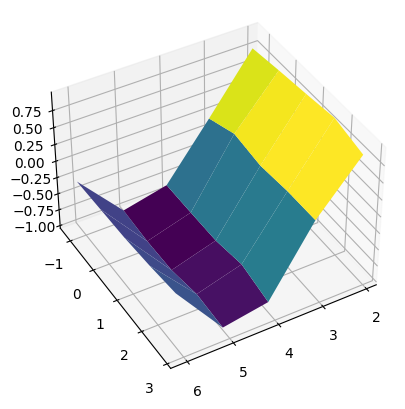

[[ 0.56555403  0.99954073  0.51455429 -0.44351099 -0.99381431]
 [ 0.56555403  0.99954073  0.51455429 -0.44351099 -0.99381431]
 [ 0.56555403  0.99954073  0.51455429 -0.44351099 -0.99381431]
 [ 0.56555403  0.99954073  0.51455429 -0.44351099 -0.99381431]
 [ 0.56555403  0.99954073  0.51455429 -0.44351099 -0.99381431]]
[[ 0.47246777  1.05742931  0.45605942 -0.46592542 -0.92554931]
 [ 0.65901732  1.00103432  0.58687151 -0.38995089 -1.02453881]
 [ 0.59955548  0.91335623  0.43145337 -0.47285455 -0.90833809]
 [ 0.59438535  1.03053988  0.43670169 -0.52741547 -0.99776114]
 [ 0.5261444   1.07918978  0.60064866 -0.44443955 -1.03371784]]


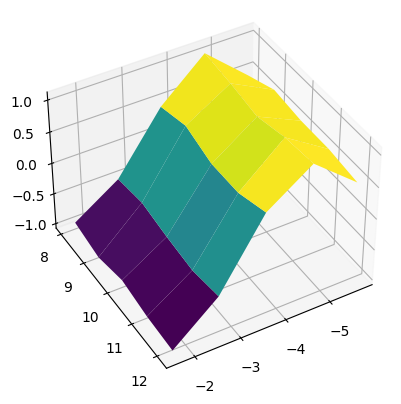

**************
[[-0.71926461 -0.71926461 -0.71926461 -0.71926461 -0.71926461]
 [-0.9732207  -0.9732207  -0.9732207  -0.9732207  -0.9732207 ]
 [-0.33240217 -0.33240217 -0.33240217 -0.33240217 -0.33240217]
 [ 0.61402538  0.61402538  0.61402538  0.61402538  0.61402538]
 [ 0.99592083  0.99592083  0.99592083  0.99592083  0.99592083]]
[[-0.64227811 -0.68562102 -0.63388766 -0.77881766 -0.70994957]
 [-0.89623421 -0.93957711 -0.88784376 -1.03277376 -0.96390567]
 [-0.25541568 -0.29875859 -0.24702523 -0.39195523 -0.32308714]
 [ 0.69101188  0.64766897  0.69940233  0.55447233  0.62334041]
 [ 1.07290733  1.02956442  1.08129778  0.93636778  1.00523587]]


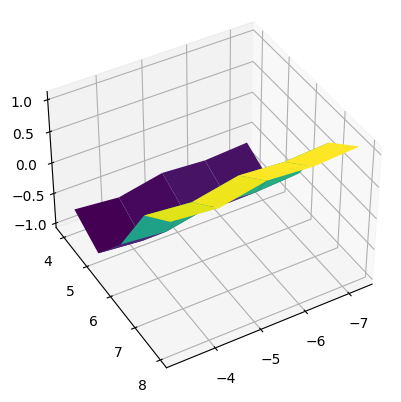

[[ 0.9975971   0.9975971   0.9975971   0.9975971   0.9975971 ]
 [ 0.597303    0.597303    0.597303    0.597303    0.597303  ]
 [-0.35214872 -0.35214872 -0.35214872 -0.35214872 -0.35214872]
 [-0.97783653 -0.97783653 -0.97783653 -0.97783653 -0.97783653]
 [-0.70450595 -0.70450595 -0.70450595 -0.70450595 -0.70450595]]
[[ 0.96989611  1.03648938  0.9310665   0.98999199  1.05282659]
 [ 0.56960201  0.63619529  0.5307724   0.5896979   0.6525325 ]
 [-0.37984971 -0.31325644 -0.41867932 -0.35975383 -0.29691922]
 [-1.00553752 -0.93894425 -1.04436713 -0.98544164 -0.92260704]
 [-0.73220694 -0.66561367 -0.77103655 -0.71211106 -0.64927645]]


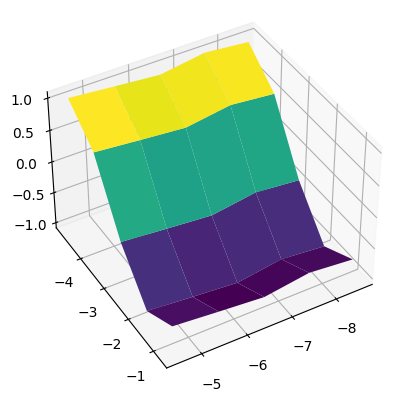

In [20]:
n_pts = 5
scale = 1
period = 1
eps = 0.1


for i in range(10):
    X,Y,Z, ar = random_surface_sin_x(n_pts, scale = scale, period = period, eps = eps)
    kf.plot_surface(X,Y,Z)

print("**************")
for i in range(10):
    X,Y,Z, ar = random_surface_sin_y(n_pts, scale = scale, period = period, eps = eps)
    kf.plot_surface(X,Y,Z)

# 1. Generate the data  

[[0, 1, 5], [1, 2, 6], [1, 5, 6], [2, 3, 7], [2, 6, 7], [3, 4, 8], [3, 7, 8], [4, 8, 9], [5, 6, 10], [6, 7, 11], [6, 10, 11], [7, 8, 12], [7, 11, 12], [8, 9, 13], [8, 12, 13], [9, 13, 14], [10, 11, 15], [11, 12, 16], [11, 15, 16], [12, 13, 17], [12, 16, 17], [13, 14, 18], [13, 17, 18], [14, 18, 19], [15, 16, 20], [16, 17, 21], [16, 20, 21], [17, 18, 22], [17, 21, 22], [18, 19, 23], [18, 22, 23], [19, 23, 24]]


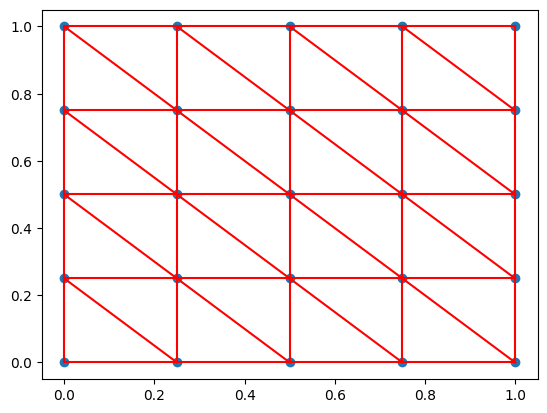

In [21]:
num_pts = 5
pts , ac = kf.plot_unit_square_grid(num_pts)
simplices = []
for s in ac.get_skeleton(2):
    if len(s[0]) == 3: 
        simplices.append(s[0])

print(simplices)

In [22]:
# generate surface data

num_surf = 60

scale = 1
period = 1
eps = 0.1

s0 = generate_surfaces_sin_x(num_surf, num_pts , scale = scale, period = period, eps = eps)
s1 = generate_surfaces_sin_y(num_surf, num_pts , scale = scale, period = period, eps = eps)

surfaces = s0 + s1 

# generate labels
labels = np.concatenate((np.zeros(num_surf),np.ones(num_surf)))

# perform a one hot encoding of the labels and transform to torch
labels_one_hot = torch.nn.functional.one_hot(torch.tensor(labels).to(torch.int64))

## shuffle the data and the labels in the same way
shuffled_indices = torch.randperm(len(surfaces)) 
surfaces_shuffled = [surfaces[i] for i in shuffled_indices]
labels_one_hot_shuffled = labels_one_hot[shuffled_indices]
labels_shuffled = labels[shuffled_indices]

[[-0.17839373  0.73158656  0.96894954  0.31546478 -0.62805684]
 [-0.17839373  0.73158656  0.96894954  0.31546478 -0.62805684]
 [-0.17839373  0.73158656  0.96894954  0.31546478 -0.62805684]
 [-0.17839373  0.73158656  0.96894954  0.31546478 -0.62805684]
 [-0.17839373  0.73158656  0.96894954  0.31546478 -0.62805684]]
[[-0.11340118  0.73312846  1.02720831  0.23747087 -0.69715431]
 [-0.26017867  0.71079719  0.89597389  0.21881399 -0.58063404]
 [-0.25350133  0.68354961  0.86898725  0.25134861 -0.69997316]
 [-0.1574499   0.83097175  0.87909041  0.29100876 -0.69718871]
 [-0.08665187  0.78459868  0.96142137  0.33037198 -0.53032919]]
[[ 0.5972146  -0.35225188 -0.9778596  -0.70442772  0.21665176]
 [ 0.5972146  -0.35225188 -0.9778596  -0.70442772  0.21665176]
 [ 0.5972146  -0.35225188 -0.9778596  -0.70442772  0.21665176]
 [ 0.5972146  -0.35225188 -0.9778596  -0.70442772  0.21665176]
 [ 0.5972146  -0.35225188 -0.9778596  -0.70442772  0.21665176]]
[[ 0.68375843 -0.31455388 -1.04725584 -0.62855553  0

In [23]:
## making dictionaries out of the surfaces

surfaces_list = []
for surf in range(num_surf*2): 
    surface = surfaces[surf]
    surface_dict= {}
    surface_dict['simplices'] = simplices

    translation = torch.tensor(np.random.uniform(-10, 10, 3))
    
    surface_dict['points'] = surface[3]
    surface_dict['Phi'] = []
    surface_dict['b'] = []
    


    for i in range(len(surface_dict['simplices'])):
        s = surface_dict['simplices'][i]
        emb_vertices_simplex = surface_dict['points'][s]
        phi_simplex, b_simplex = kf.phi_b(emb_vertices_simplex )
        surface_dict['Phi'].append(phi_simplex)
        surface_dict['b'].append(b_simplex)

    surfaces_list.append(surface_dict)

surfaces_list_shuffled = [surfaces_list[i] for i in shuffled_indices]

len(surfaces_list_shuffled)

40

# 2. Classification 

In [24]:
k = 2 
dim = 3 
## Precomputed things: 
det = kf.build_determinant_tensor(dim, k) ## will be needed for integration 
print(k)
print(dim)
print(det.shape)

num_sub = 2
vertices, coefs = kf.subdivide_simplex_coef_torch(num_sub)


2
3
torch.Size([3, 3, 3])


In [27]:
classes = 2
num_cochains = 2 ## number of k-forms to learn 

N = int(scipy.special.binom(dim,k))

kforms = nn.Sequential(
    nn.Linear(dim, 50),
    nn.ReLU(),
    nn.Linear(50, 50),
    nn.ReLU(),
    nn.Linear(50, N*num_cochains) ## can add layers here if needed
)

In [28]:
epochs = 60

# create your optimizer
#lr = 0.1 
#lr = 1e-2 
lr = 0.1

lr = 1e-1
#

optimizer = optim.SGD(kforms.parameters(), lr) 

criterion = nn.CrossEntropyLoss()

losses = torch.zeros(epochs)

labels_one_hot_shuffled = labels_one_hot_shuffled.to(torch.float32)

torch.autograd.set_detect_anomaly(True)

Accuracies = []
Losses= []

for e in range(epochs):
    print('epoch: ', e)
    
    correct = 0
    total = 0

    for i in range(len(surfaces_list_shuffled)):
        surface_dict= surfaces_list_shuffled[i]
        l = labels_one_hot_shuffled[i]
        
        X = kf.forms2cochains(kforms, surface_dict, det,vertices, coefs, num_sub, num_cochains, dim, k) ## multiple cochains 
        X = torch.reshape(X, (len(surface_dict['simplices']), num_cochains))
        X.retain_grad() 
        X = X.sum(0)
        X.retain_grad()
        #X.grad = None
        # softmax
        sm = torch.nn.functional.softmax(X)
        #print('softmax = ',sm)
        loss = criterion(sm,l) 
        print("loss: ", loss)
        #print('********')
        loss.backward(retain_graph=True)
        optimizer.step()
        optimizer.zero_grad()
        
        pred = torch.argmax(torch.nn.functional.softmax(X))
        #print('pred: ', pred)
        #print('label: ', torch.argmax(l))
        if pred == torch.argmax(l):
            correct += 1
        total += 1
        #print('correct: ', correct)

        if i % 10 == 0:
            print("number of surfaces processed: ", i)

    print('Accuracy of the network on the {} training surfaces at epoch {} : {} '.format(num_surf*2, e, (100 * correct / total)))
    Accuracies.append(100 * correct / total)
    Losses.append(loss)

    print('-----------')
    print('***********')
    print('-----------')



epoch:  0


/Users/celiahacker/opt/anaconda3/envs/celia/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


loss:  tensor(0.5991, grad_fn=<DivBackward1>)


/Users/celiahacker/opt/anaconda3/envs/celia/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


number of surfaces processed:  0
loss:  tensor(0.7432, grad_fn=<DivBackward1>)
loss:  tensor(0.7264, grad_fn=<DivBackward1>)
loss:  tensor(0.7157, grad_fn=<DivBackward1>)
loss:  tensor(0.6370, grad_fn=<DivBackward1>)
loss:  tensor(0.6686, grad_fn=<DivBackward1>)
loss:  tensor(0.8183, grad_fn=<DivBackward1>)
loss:  tensor(0.7940, grad_fn=<DivBackward1>)
loss:  tensor(0.6111, grad_fn=<DivBackward1>)
loss:  tensor(0.6949, grad_fn=<DivBackward1>)
loss:  tensor(0.6059, grad_fn=<DivBackward1>)
number of surfaces processed:  10
loss:  tensor(0.5481, grad_fn=<DivBackward1>)
loss:  tensor(0.8988, grad_fn=<DivBackward1>)
loss:  tensor(0.9064, grad_fn=<DivBackward1>)
loss:  tensor(0.7623, grad_fn=<DivBackward1>)
loss:  tensor(0.6053, grad_fn=<DivBackward1>)
loss:  tensor(0.6632, grad_fn=<DivBackward1>)
loss:  tensor(0.6321, grad_fn=<DivBackward1>)
loss:  tensor(0.6485, grad_fn=<DivBackward1>)
loss:  tensor(0.6759, grad_fn=<DivBackward1>)
loss:  tensor(0.7567, grad_fn=<DivBackward1>)
number of sur

KeyboardInterrupt: 

In [29]:
try_num = 4
filename = 'multiple_cochains_try'+str(try_num)

In [30]:
## save the data
import pickle
Losses = [loss.detach() for loss in Losses]
with open('kforms/sine_functions/'+filename+'_losses.pkl', 'wb') as f:
    pickle.dump(Losses, f)

# dump accuracies into a pickle file
with open('kforms/sine_functions/'+filename+'_accuracies.pkl', 'wb') as f:
    pickle.dump(Accuracies, f)

# save the model
torch.save(kforms.state_dict(), 'kforms/sine_functions/'+filename+'_kform_model.pt')

# save the surfaces
with open('kforms/sine_functions/'+filename+'_surfaces.pkl', 'wb') as f:
    pickle.dump(surfaces_list, f)

# Plots

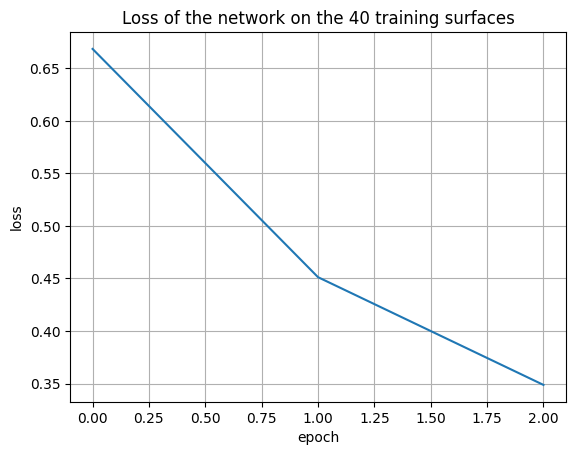

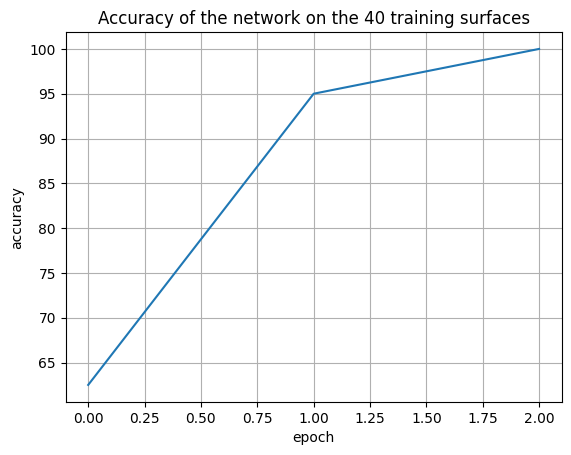

In [31]:
# plot the loss
fig, ax = plt.subplots()
ax.plot(np.arange(len(Losses)), Losses)
ax.set(xlabel='epoch', ylabel='loss', title='Loss of the network on the {} training surfaces'.format(num_surf*2))
ax.grid()
plt.show()

# plot the accuracy
fig, ax = plt.subplots()
ax.plot(np.arange(len(Accuracies)), Accuracies)
ax.set(xlabel='epoch', ylabel='accuracy', title='Accuracy of the network on the {} training surfaces'.format(num_surf*2))
ax.grid()
plt.show()

In [32]:
cochains = []
for i in range(len(surfaces_list)):
    surface_dict= surfaces_list[i]
    cochain = kf.forms2cochains(kforms, surface_dict, det,vertices, coefs, num_sub, num_cochains, dim, k) ## multiple cochains 
    cochain = cochain.detach().numpy()
    cochains.append(cochain)

# dump cochains into a pickle file
with open('kforms/sine_functions/'+filename+'_cochains.pkl', 'wb') as f:
    pickle.dump(cochains, f)